In [ ]:
from google.colab import files

# Upload the zip file
uploaded = files.upload()


Saving archive (1).zip to archive (1).zip


In [ ]:
import zipfile
import io

# Specify the file name
zip_file_name = "archive (1).zip"

# Unzip the file
with zipfile.ZipFile(io.BytesIO(uploaded[zip_file_name]), 'r') as zip_ref:
    zip_ref.extractall("fer2013")

In [ ]:
!pip install --upgrade pandas


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

# Assuming img_width and img_height are your image dimensions
img_width, img_height = 48, 48
epochs = 15
batch_size = 64

# Define the path to your images
data_path = "fer2013"

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    'fer2013/train',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

val_generator = datagen.flow_from_directory(
    'fer2013/test',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(train_generator.num_classes, activation='softmax'))

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the model
history=model.fit(train_generator, epochs=epochs, validation_data=val_generator)

# Evaluate the model
loss, accuracy = model.evaluate(val_generator)
print(f'Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}')


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 10, 10, 64)        0         
                                                                 
 flatten (Flatten)           (None, 6400)              0

113/113 [==============================] - 5s 45ms/step - loss: 1.2160 - accuracy: 0.5401

Test Loss: 1.2160
Test Accuracy: 54.01%
113/113 [==============================] - 3s 26ms/step

Test Accuracy: 0.18096962942323766

Classification Report:
              precision    recall  f1-score   support

       angry       0.14      0.15      0.15       958
     disgust       0.00      0.00      0.00       111
        fear       0.14      0.06      0.09      1024
       happy       0.25      0.27      0.26      1774
     neutral       0.18      0.20      0.19      1233
         sad       0.17      0.22      0.19      1247
    surprise       0.12      0.11      0.12       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.18      0.18      0.18      7178



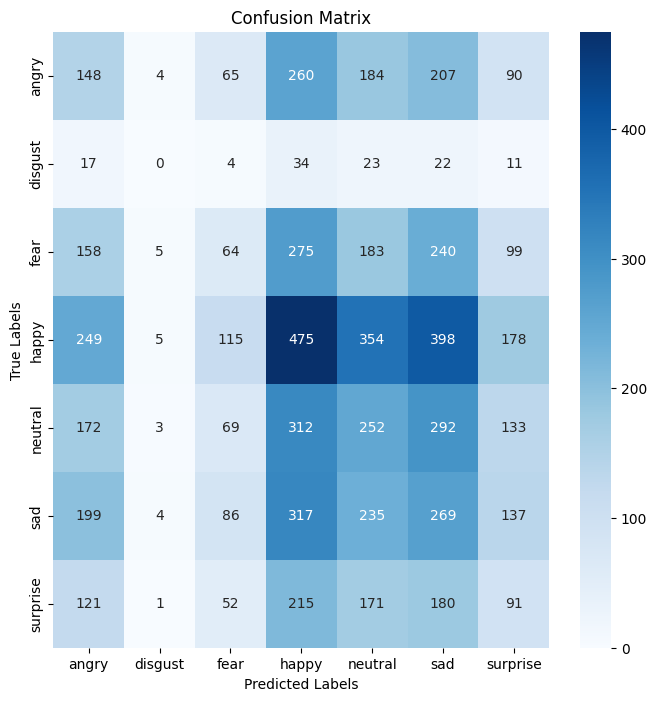

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


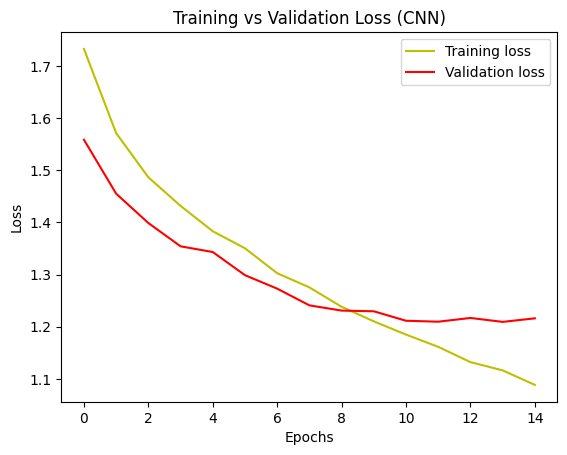

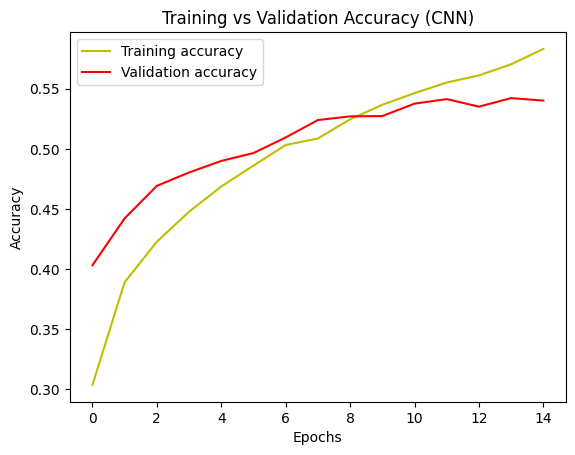

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
#from pandas.api.types import SparseDtype

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(val_generator)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predictions on the entire test set
test_predictions = model.predict(val_generator)
predicted_labels = np.argmax(test_predictions, axis=1)

# Get true labels from the generator
true_labels = val_generator.classes

# Accuracy
test_accuracy_cnn = accuracy_score(true_labels, predicted_labels)
print("\nTest Accuracy:", test_accuracy_cnn)

# Classification Report
emotion_labels = sorted(train_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=emotion_labels))

# Confusion Matrix
cm_cnn = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 8))
sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print keys in the history object
print(history.history.keys())

# Plot the overall training and validation loss for CNN
plt.plot(history.history['loss'], 'y', label='Training loss')
plt.plot(history.history['val_loss'], 'r', label='Validation loss')
plt.title('Training vs Validation Loss (CNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the overall training and validation accuracy for CNN
plt.plot(history.history['accuracy'], 'y', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'r', label='Validation accuracy')
plt.title('Training vs Validation Accuracy (CNN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




1/1 [==============================] - 0s 71ms/step


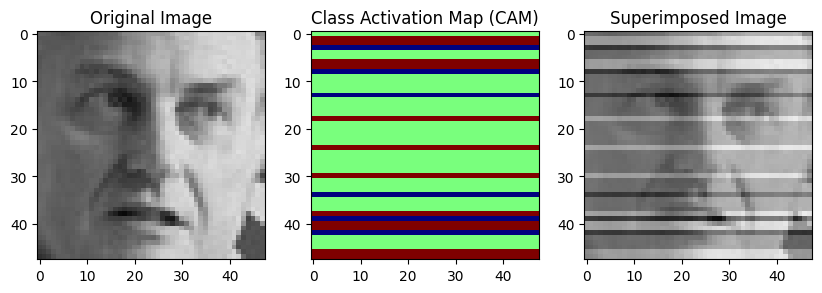

In [ ]:
from keras.models import Model
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Get the output of the last convolutional layer
last_conv_layer = model.layers[-4]

# Create a new model that includes the layers up to the last convolutional layer
cam_model = Model(inputs=model.input, outputs=(last_conv_layer.output, model.output))

# Choose an image from the validation set for CAM visualization
#You can choose whichever image you want from the files section
sample_img_path = 'fer2013/test/sad/PrivateTest_10247676.jpg'

# Choose the class index for which you want to generate CAM
class_index = 0  # Adjust this based on your class indices

# Load the original image
original_img = cv2.imread(sample_img_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Preprocess the image for the CAM model
img = cv2.resize(original_img, (img_width, img_height))
img = img / 255.0
img = np.expand_dims(img, axis=0)

# Get the output of the last convolutional layer and the final prediction
last_conv_output, pred = cam_model.predict(img)
last_conv_output = last_conv_output[0]

# Get the class activation map
cam = np.dot(last_conv_output, model.get_layer('dense').get_weights()[0][:, class_index])

# Upsample to the original image size
upsampled_cam = cv2.resize(np.array(cam), (original_img.shape[1], original_img.shape[0]))

# Normalize the CAM values between 0 and 1
upsampled_cam = upsampled_cam - np.min(upsampled_cam)
upsampled_cam = upsampled_cam / np.max(upsampled_cam)
upsampled_cam *= 255.0 / upsampled_cam.max()

# Convert the upsampled CAM to 3 channels
upsampled_cam = cv2.cvtColor(np.uint8(upsampled_cam), cv2.COLOR_GRAY2RGB)

# Superimpose the CAM on the original image
heatmap = cv2.applyColorMap(np.uint8(255 * upsampled_cam), cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(original_img, 0.6, upsampled_cam, 0.4, 0)

#  Display the original image, CAM, and superimposed image
plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.imshow(original_img)
plt.title('Original Image')
plt.subplot(132)
plt.imshow(upsampled_cam[:, :, 0], cmap='jet')  # Display one channel of CAM
plt.title('Class Activation Map (CAM)')
plt.subplot(133)
plt.imshow(superimposed_img)
plt.title('Superimposed Image')
plt.show()
